In [1]:
%matplotlib notebook
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def coarse(t):
    return t

def coarse_exact(t, t0, u0):
    return u0 + t - t0

def fine(t):
    return t + np.sin(np.pi/2.0*t)

def exact_solver(t, t0, u0):
    return u0 + t - t0 + np.sin(np.pi/2.0*t) - np.sin(np.pi/2.0*t0)

In [3]:
def create_variable(size):
    std = np.sqrt(2.0 / size[1])
    return tf.Variable(tf.random_normal(shape=size, stddev=std))

def feed_forward_NN(x, W, b):
    A = x
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(W[i], A), b[i]))
    return tf.add(tf.matmul(W[-1], A), b[-1])

<IPython.core.display.Javascript object>


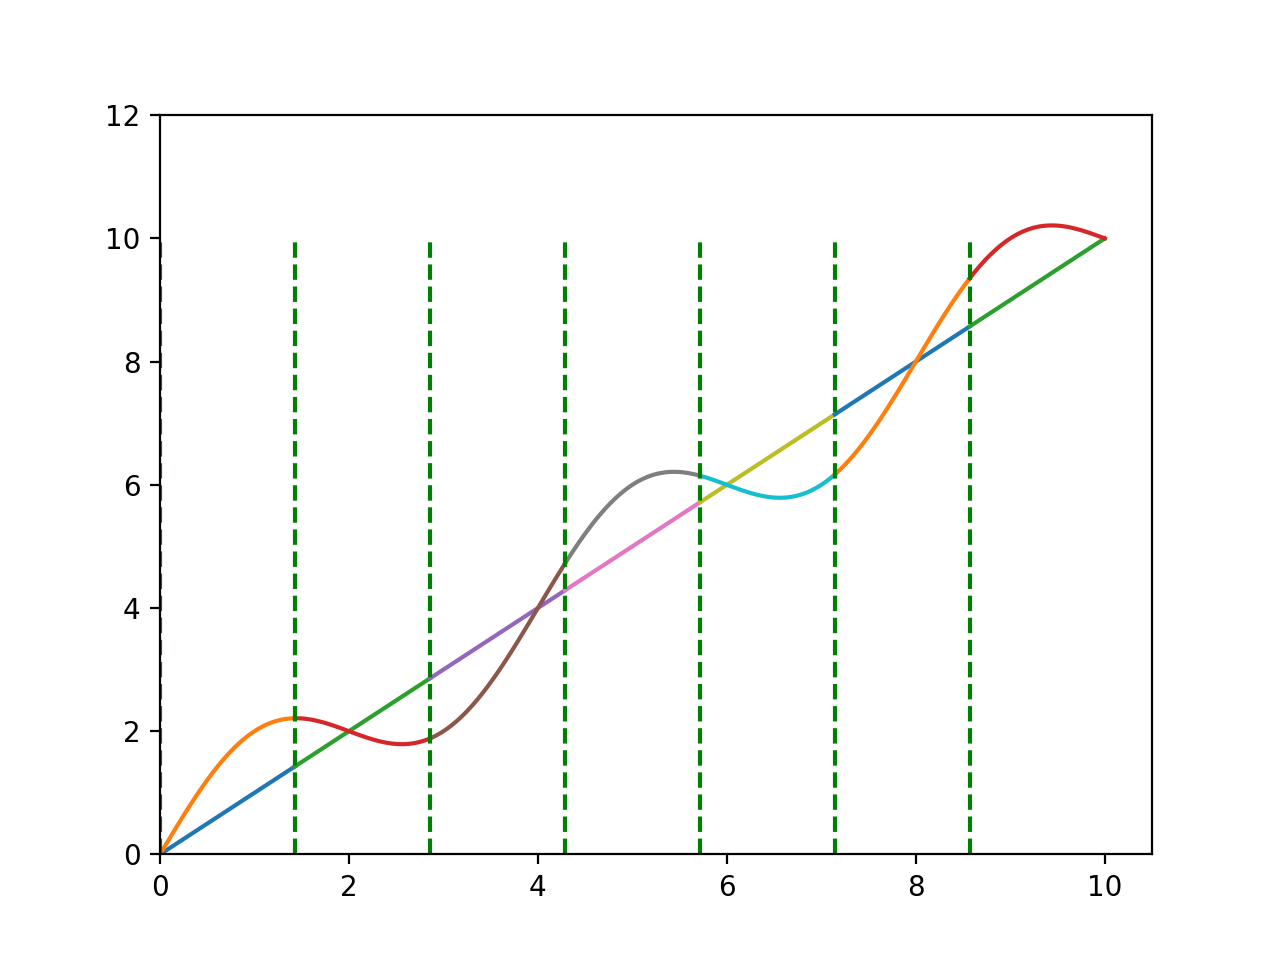

In [4]:
t_range = [0, 10]
N = 7
chunks = np.linspace(t_range[0], t_range[1], N+1)
tt = []
uc_list = []
uf_list = []

uc_0 = 0
uf_0 = 0

fig0 = plt.figure()
ax = fig0.add_subplot(1,1,1)
ax.set_xlim(0,10.5)
ax.set_ylim(0,12)

fig0.show()
fig0.canvas.draw()

for i in range(N):
    t_current = np.linspace(chunks[i], chunks[i+1], 101)
    uc_current = coarse_exact(t_current, t_current[0], uc_0)
    uf_current = exact_solver(t_current, t_current[0], uf_0)
    
    uc_0 = uc_current[-1]
    uf_0 = uf_current[-1]
    
    tt.append(t_current)
    uc_list.append(uc_current)
    uf_list.append(uf_current)
    
    plt.plot(t_current, uc_current)
    plt.plot(t_current, uf_current)
    plt.plot(chunks[i]*np.ones(100), np.linspace(0, 10, 100), 'g--')
    fig0.canvas.draw()
    time.sleep(1.5)

In [5]:
tf.reset_default_graph()
tf.random.set_random_seed(1234)

## Coarse PINN Solver (Single PINN)

In [6]:
# Coarse NN
layer_dims = [1] + 2*[4] + [1]
L = len(layer_dims)
W_coarse = [create_variable([layer_dims[l], layer_dims[l-1]]) for l in range(1, L)]
b_coarse = [create_variable([layer_dims[l], 1]) for l in range(1, L)]


t_coarse = tf.placeholder(shape=[1,None], dtype=tf.float32)
t_mean = 0.5*(t_range[0] + t_range[1])

u_coarse = feed_forward_NN(t_coarse - t_mean, W_coarse, b_coarse)
u_coarse_dt = tf.gradients(u_coarse, t_coarse)[0]
rhs_coarse = tf.placeholder(shape=[1,None], dtype=tf.float32)

MSE_f_coarse = tf.reduce_mean(tf.square(u_coarse_dt - rhs_coarse))

tb_coarse = tf.placeholder(shape=[1,None], dtype=tf.float32)
ub_coarse = feed_forward_NN(tb_coarse - t_mean, W_coarse, b_coarse)
bc_coarse = tf.placeholder(shape=[1,None], dtype=tf.float32)

MSE_b_coarse = tf.reduce_mean(tf.square(ub_coarse - bc_coarse))

loss_coarse = MSE_f_coarse + MSE_b_coarse
train_coarse = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_coarse, var_list=[W_coarse, b_coarse])

In [7]:
# Coarse solver data
n_coarse_col = 20
Coarse_colpoints = np.linspace(t_range[0], t_range[1], n_coarse_col)
Coarse_rhs = np.ones(n_coarse_col)

In [8]:
def coarse_solver(sess, t, t0, u0):
    train_dict = {t_coarse: Coarse_colpoints[None],
                  rhs_coarse: Coarse_rhs[None],
                  tb_coarse: np.reshape(t0, [1,-1]),
                  bc_coarse: np.reshape(u0, [1,-1])}
    
    num_epoch = 5000
    loss = float('Inf')
    niter = 0
    while niter < num_epoch:
        niter += 1
        _, loss = sess.run([train_coarse, loss_coarse], feed_dict=train_dict)
        
    test_dict = {t_coarse: np.reshape(t, [1,-1])}
    u_test = sess.run(u_coarse, feed_dict=test_dict)
    
    return np.squeeze(u_test)

## Fine PINN Solver (Multiple PINNs)

In [9]:
layer_dims = [1] + 3*[16] + [1]
L = len(layer_dims)

Weights = []
Biases = []
for i in range(N):
    W = [create_variable([layer_dims[l], layer_dims[l-1]]) for l in range(1, L)]
    b = [create_variable([layer_dims[l], 1]) for l in range(1, L)]
    Weights.append(W)
    Biases.append(b)

T = []
Rhs = []
Tb = []
Bc = []
Loss = []
Train = []
Unn = []
Shift = []
for i in range(N):
    shift = tf.placeholder(shape=[], dtype=tf.float32)
    t = tf.placeholder(shape=[1,None], dtype=tf.float32)
    
    u = feed_forward_NN(t - shift, Weights[i], Biases[i])
    u_dt = tf.gradients(u, t)[0]
    rhs = tf.placeholder(shape=[1,None], dtype=tf.float32)
    
    MSE_f = tf.reduce_mean(tf.square(u_dt - rhs))
    
    tb = tf.placeholder(shape=[1,None], dtype=tf.float32)
    ub = feed_forward_NN(tb - shift, Weights[i], Biases[i])
    bc = tf.placeholder(shape=[1,None], dtype=tf.float32)
    
    MSE_b = tf.reduce_mean(tf.square(ub - bc))
    
    loss = MSE_f + MSE_b
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss, var_list=[Weights[i], Biases[i]])
    
    Shift.append(shift)
    T.append(t)
    Rhs.append(rhs)
    Tb.append(tb)
    Bc.append(bc)
    Loss.append(loss)
    Train.append(train)
    Unn.append(u)

In [10]:
# Fine solver data
ColPoints = []
Residue = []
MidPoint = []
for i in range(N):
    t_col = np.linspace(chunks[i], chunks[i+1], 101)
    rhs = 1.0 + np.pi / 2.0 * np.cos(np.pi / 2.0 * t_col)
    
    ColPoints.append(np.reshape(t_col, [1,-1]))
    Residue.append(np.reshape(rhs, [1, -1]))
    MidPoint.append(0.5*(chunks[i]+chunks[i+1]))

In [11]:
def fine_solver(sess, chunk_id, t, t0, u0):
    
    train_dict = {Shift[chunk_id]: MidPoint[chunk_id],
                  T[chunk_id]: ColPoints[chunk_id],
                  Rhs[chunk_id]: Residue[chunk_id],
                  Tb[chunk_id]: np.reshape(t0, [1,-1]),
                  Bc[chunk_id]: np.reshape(u0, [1,-1])}
    
    num_epoch = 50000
    loss = float('Inf')
    niter = 0
    while loss > 1e-6 and niter < num_epoch:
        niter += 1
        _, loss = sess.run([Train[chunk_id], Loss[chunk_id]], feed_dict=train_dict)
    
    print('Chunk #', chunk_id, ':', niter)
    
    test_dict = {Shift[chunk_id]: np.mean(ColPoints[chunk_id]), 
                 T[chunk_id]: np.reshape(t, [1,-1])}
    u_test = sess.run(Unn[chunk_id], feed_dict=test_dict)
    
    return np.squeeze(u_test)

## Begin Training

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

<IPython.core.display.Javascript object>


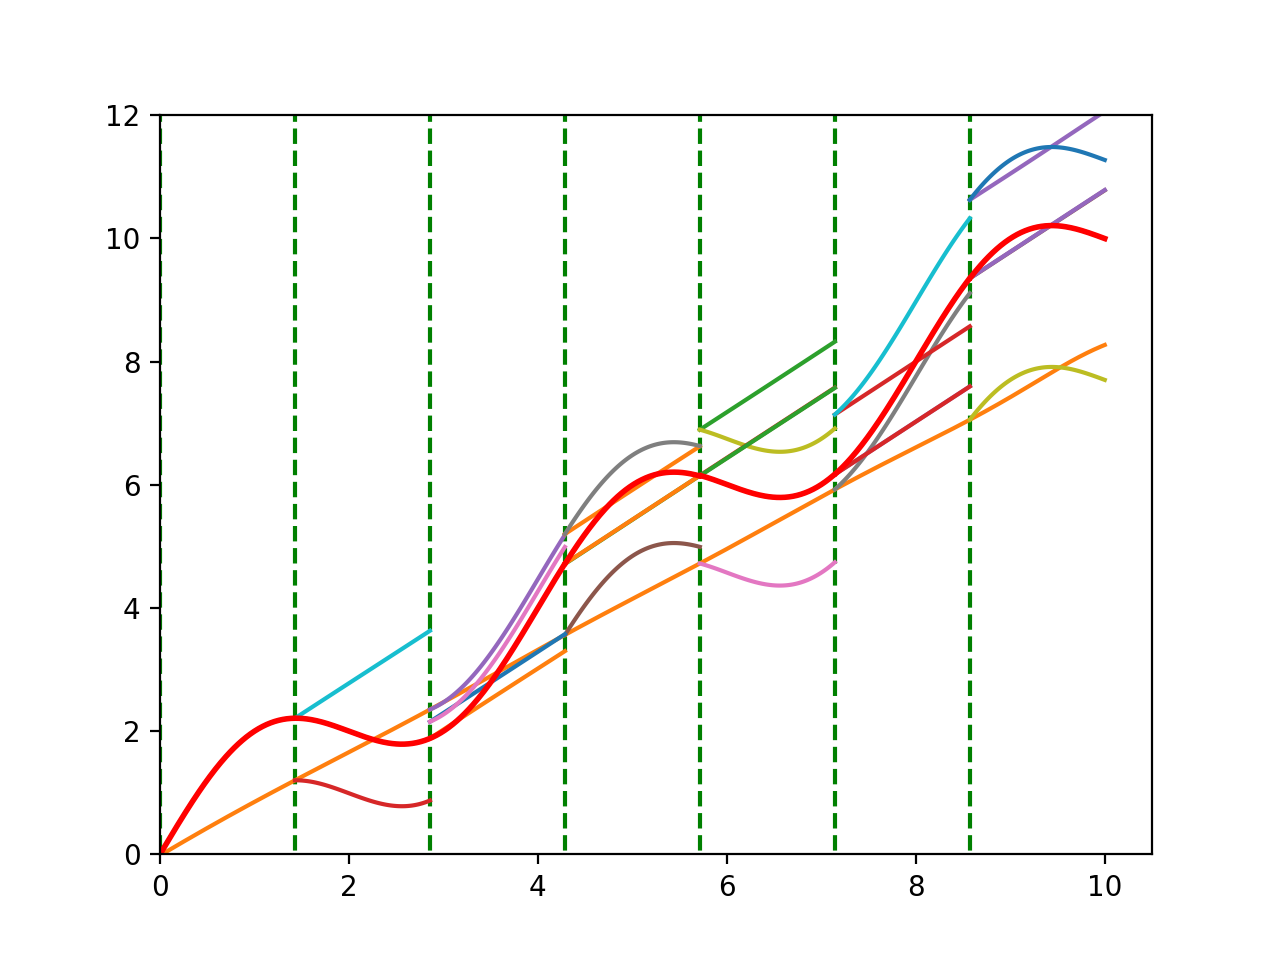

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0,10.5)
ax.set_ylim(0,12)

for i in range(N):
    plt.plot(chunks[i]*np.ones(101), np.linspace(-5, 15, 101), 'g--')

t_plot = np.concatenate(tt)
plt.plot(t_plot, exact_solver(t_plot, 0, 0), '--', linewidth=0.5)

fig.show()
fig.canvas.draw()

In [14]:
# initial condition U(t0) = u0
u0 = 0
U = [u0] + [0 for i in range(N)]
G = [0 for i in range(N)]
F = [0 for i in range(N)]

# Pass #0:
t_full = np.concatenate(tt)
uc = coarse_solver(sess, t_full, t_range[0], u0)
uc_2d = np.reshape(uc, [N, -1])
for n in range(N):
    U[n+1] = uc_2d[n, -1]
    G[n] = uc_2d[n, -1]
    
plt.plot(t_full, uc)
fig.canvas.draw()

In [15]:
niter = 1
while niter <= N:
    # fine solver (parallel)
    for n in range(niter-1, N):
        t_current = tt[n]
        uf_current = fine_solver(sess, n, t_current, chunks[n], U[n])
        F[n] = uf_current[-1]
        
        uf_list[n] = uf_current
        plt.plot(t_current, uf_current)
        fig.canvas.draw()
        
    # coarse solver (serial)
    error = 0
    G_new = G[niter-1]
    for n in range(niter, N):
        error += np.abs(G_new - G[n-1])
        U[n] = G_new - G[n-1] + F[n-1]
        G[n-1] = G_new
        t_current = tt[n]
        uc_current = coarse_solver(sess, t_current, chunks[n], U[n])
        G_new = uc_current[-1]
        
        uc_list[n] = uc_current
        plt.plot(t_current, uc_current)
        fig.canvas.draw()
        
    # check error
    print('Iteratoin:', niter, ';  Error:', error / (N - niter + 1e-10))
    if error / (N - niter + 1e-10) < 1e-2:
        break
    
    niter += 1

if niter < N:
    print('Awesome! Error converges, iteration terminated.')
else:
    print('Oops! Maximum number of iteration is used.')

Chunk # 0 : 5745
Chunk # 1 : 6009
Chunk # 2 : 12141
Chunk # 3 : 13365
Chunk # 4 : 12912
Chunk # 5 : 20027
Chunk # 6 : 12119
Iteratoin: 1 ;  Error: 1.1846418777904162
Chunk # 1 : 4154
Chunk # 2 : 1994
Chunk # 3 : 5303
Chunk # 4 : 8556
Chunk # 5 : 5170
Chunk # 6 : 10047
Iteratoin: 2 ;  Error: 0.49451665877306866
Chunk # 2 : 3890
Chunk # 3 : 1439
Chunk # 4 : 2008
Chunk # 5 : 5110
Chunk # 6 : 5884
Iteratoin: 3 ;  Error: 0.001990675926158729
Awesome! Error converges, iteration terminated.


In [16]:
uf_plot = np.concatenate(uf_list)
plt.plot(t_plot, uf_plot, 'r-', linewidth=2)
fig.canvas.draw()

In [17]:
sess.close()